<a name="top"> <h1>2.5. Light GBM</h1> <a>

<p>Payments Fraud Practice<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F1 y F2 score
   - Curva ROC

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento, nos centraremos en la creación de un **Modelo Light GBM**.


LightGBM es un método de ensamblaje de refuerzo de gradientes que se basa en árboles de decisión. Al igual que con otros métodos basados en árboles de decisión, LightGBM se puede utilizar tanto para la clasificación como para la regresión. LightGBM está optimizado para un alto rendimiento con sistemas distribuidos.




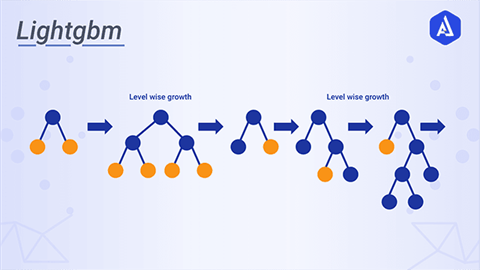

Una vez creado el modelo, procederemos a optimizarlo con los valores de train y predecir los valores de validación.


# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias necesarias para la creación y optimización del modelo XGBoost:

In [16]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score,roc_auc_score,plot_confusion_matrix

# Import sklearn models and pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import lightgbm as lgb

Importamos las funciones a utilizar:

In [2]:
# Import the functions used in the notebook.

from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
# Import the preprocessor.

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [7]:
# Load the train dataset separated by other variables and target. Taking into account that the first column is the index.

x_train = pd.read_csv("../data/processed/x_train.csv",index_col=0 )
y_train = pd.read_csv("../data/processed/y_train.csv",index_col=0 )

# Load the validation dataset separated by other variables and target. Taking into account that the first column is the index.

x_val = pd.read_csv("../data/processed/x_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

# <a name="creacion"> 3. Creación del modelo <a> 

Para la creación del modelo **LightGBM**  utilizaremos el algoritmo LGBMClassifier de la libreria _lightgbm_.

Creamos un Pipeline que ejecute el preprocesado primero y el algoritmo _LightGBM_ después.

Para el algoritmo designaremos los parámetros por default, pero utilizaremos todo el procesador para agilizar el proceso.

In [4]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

lightgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', lgb.LGBMClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])


# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [9]:
# Optimization of the light_gbm with the train set: input and target data. 

lightgbm_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknow',
                                                                                 strategy='constant',
                                                                                 verbose='deprecated')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'gender', 'device',
                                                   'zone', 'security_alert',
                                                   'nameDest', 'nameOrig',
                                                   'nameDest']),
                                        

Una vez optimizado el modelo XGB, con el set de train, procedemos a guardarlo en un pickle para que no se tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [10]:
# Save the backup of the XGB optimziation as a pickle file.

save_model(lightgbm_model,'../models/lightgbm_model.pickle')

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [9]:
# Load the XGB model already fitted in /models.

lightgbm_model = load_model('../models/lightgbm_model.pickle')


# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo Light GBM, procederemos a predecir el set de validación, sus valores y probabilidades. Para posteriormente obtener las métricas y observar como se comporta el modelo y su score.

In [10]:
# Predict the target value of the validation set.

predictions = lightgbm_model.predict(x_val)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = lightgbm_model.predict_proba(x_val)

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este aparatado procederemos a análizar las métricas obtenidas. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`.

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[196042    352]
 [   132     82]]
Normalized confusion matrix
[[0.99820768 0.00179232]
 [0.61682243 0.38317757]]


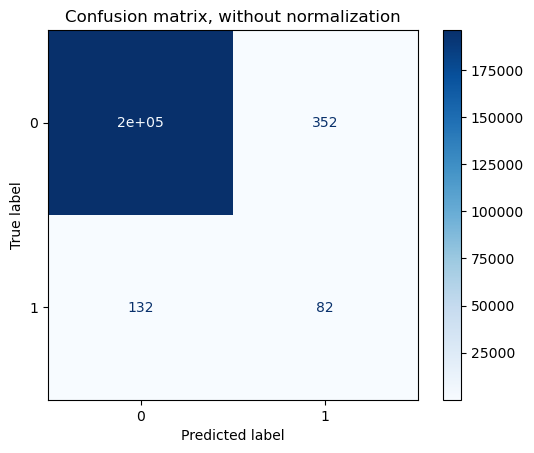

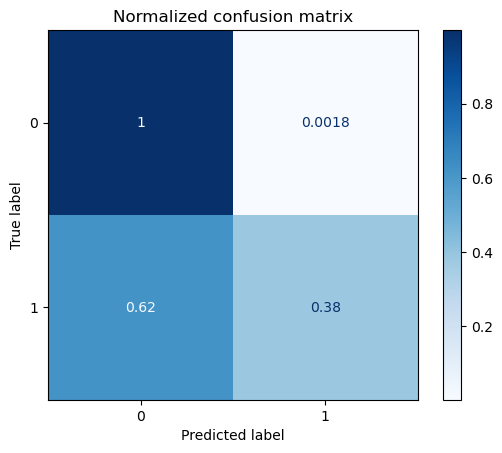

In [13]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(lightgbm_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Observando la matriz de confusión normalizada **se puede observar como con la clase 1 que realmente es la que nos interesa predecir, comete un fallo del 62% y un acierto del 38%**. Valor más bajo de lo deseado, sin embargo continuamos con el análisis del resto de métricas.

### 6.2. Métricas: Accuracy, Recall, Precision, F1  y F2 score

In [19]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    196394
           1       0.19      0.38      0.25       214

    accuracy                           1.00    196608
   macro avg       0.59      0.69      0.63    196608
weighted avg       1.00      1.00      1.00    196608



In [13]:
# Print the F2 score.

print('F2 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_val, predictions))

F2 score is 0.31782945736434104
Accuracy: 0.9975382486979166


Como ya comentamos en el documento `02_DummyModel`, nuestro dataset se caracteriza por tener un desbalanceo muy grande, es por ello que el análisis de las métricas de accuracy y precisión siempre van a ser muy elevadas, sin embargo, no reflejan la realidad predictora de nuestro modelo. Por lo que nos centraremos principalmente en las métricas F2-score y AUC .

- El modelo nos calcula un **Recall de 0.38**, valor muy bajo, dado que el modelo no llega a detectar correctamente aquellas transacciones que son fraude o no.

- El modelo nos calcula un **F2 score de 0.31**, un valor muy pobre como para considerarlo un buen modelo de predicción para nuestro objetivo.

### 6.3. Curva ROC

Para evaluar nuestro modelo, la representaremos graficamente para deducir que tan bueno es el modelo.

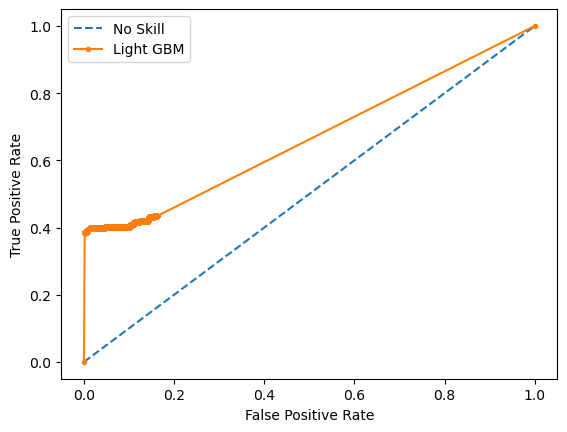

The Compute Area Under the Receiver Operating Characteristic is 0.6665730908656916


In [18]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Light GBM')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(roc_auc_score(y_val,yhat)))

Como fuimos observando desde el cálculo de la matriz de confusión, **los resultados del modelo no eran para nada convincentes, como pudimos comprobar calculando el bajo F2 y tras observar que el AUC es incluso más bajo que el resto de modelos, podemos descartarlo.** 

**El algoritmo LightGBM contiene la posibilidad de observar su explicabilidad, sin emabrgo, vistos los malos resultados, no procederemos con ello.**

[Ir arriba del documento](#top)